## The Monte Carlo simulation of the multi-factor FX-market

### The simulation of price

Import libraries:

In [1]:
import math

from mpl_toolkits.mplot3d import Axes3D # for 3D plots
import matplotlib.pyplot as plt # for 2D plots

# Basic stats libraries
import numpy as np
import statsmodels
import scipy.fftpack as fft
from scipy.linalg import cholesky
from math import exp, log, sqrt, pi

# Random number generator
from numpy import random
random.seed(seed=17001116)

# Compute the time costs
import time
#start_time = time.time()

### Generate Correlated Matrix
In this section, we are using the Cholesky decomposition matrix to generate a matrix of correlated random variables.

In [2]:
# Generate Correlated 3x3 Matrix
def generateCorrelatedMatrix3(num_steps,corr_mat):
    # Compute the (upper) Cholesky decomposition matrix
    upper_chol = cholesky(corr_mat)

    # Generate 3 series of normally distributed (Gaussian) numbers
    rnd = np.random.normal(0.0, 1.0, size=(num_steps+1, 3))

    # Finally, compute the inner product of upper_chol and rnd
    mat_ans = rnd @ upper_chol
    return  mat_ans

def generateCorrelatedMatrix2(num_steps,corr):
    # Compute the (upper) Cholesky decomposition matrix

    corr_mat = np.array([[1.0,corr],[corr,1.0]])
    upper_chol = cholesky(corr_mat)

    # Generate 2 series of normally distributed (Gaussian) numbers
    rnd = np.random.normal(0.0, 1.0, size=(num_steps+1, 2))

    # Finally, compute the inner product of upper_chol and rnd
    mat_ans = rnd @ upper_chol
    return  mat_ans

In [3]:
# Test result
corr_mat= np.array([[1.0, 0.6, 0.3],
                    [0.6, 1.0, 0.5],
                    [0.3, 0.5, 1.0]])
n_steps = 10**7

ans = generateCorrelatedMatrix3(n_steps,corr_mat)
# One can check results are consistent
from scipy.stats import pearsonr

corr_0_1 , _ = pearsonr(ans[:,0], ans[:,1])
print("The corr_0_1 is: "+str(corr_0_1))
#0.60013025775533102

corr_0_2 , _ = pearsonr(ans[:,0], ans[:,2])
print("The corr_0_2 is: "+str(corr_0_2))
#0.30049740204791148

corr_1_2 , _ = pearsonr(ans[:,1], ans[:,2])
print("The corr_1_2 is: "+str(corr_1_2))
#0.50026641543258898

W_1 = ans[:,0]
W_2 = ans[:,1]
W_3 = ans[:,2]


The corr_0_1 is: 0.599889429515325
The corr_0_2 is: 0.3000082365010643
The corr_1_2 is: 0.4998583060934801


### Heston Hybrid Model description
The model we are trying to simulate is as follows:

\begin{equation}
\begin{array}{rlr}
\mathrm{d} S_{t}= & S_{t} r_{t} \mathrm{~d} t+S_{t} \sqrt{v_{t}} \mathrm{~d} W_{t}^{v}+S_{t} \Delta \sqrt{v_{t}} \mathrm{~d} Z_{t}^{v}
 +S_{t} \Omega \mathrm{d} W_{t}^{r} \quad & t>0,  \\
\mathrm{~d} v_{t}= & \chi\left(v^{*}-v_{t}\right) \mathrm{d} t+\gamma \sqrt{v_{t}} \mathrm{~d} Z_{t}^{v} & t>0, \\
\mathrm{~d} r_{t}= & \lambda\left(\theta-r_{t}\right) \mathrm{d} t+\eta
 \sqrt{r_t}\mathrm{d} Z_{t}^{r} & t>0
\end{array}
\end{equation}

where $\Delta$ and $\Omega$ are nonnegative constants and $\chi, v^{*}, \gamma, \lambda, \theta$, $\eta$ are positive constants, while $W_{t}^{v}, W_{t}^{r}, Z_{t}^{v}, Z_{t}^{r}$ are standard Wiener processes. All correlations among the Wiener processes are zero except for the following:

\begin{equation}
\begin{aligned}
E\left[\mathrm{~d} W_{t}^{v} \mathrm{~d} Z_{t}^{v}\right] &=\rho_{v} \mathrm{~d} t,\quad &t>0 \\
E\left[\mathrm{~d} W_{t}^{r} \mathrm{~d} Z_{t}^{r}\right] &=\rho_{r} \mathrm{~d} t, \quad &t>0
\end{aligned}
\end{equation}

where the quantities $\rho_{v}, \rho_{r} \in(-1,1)$ are constant correlation coefficients.

This system of equations are equipped with the following initial condition:

\begin{equation}
S_{0}=S_{0}^{*}, \quad v_{0}=v_{0}^{*}, \quad r_{0}=r_{0}^{*}
\end{equation}

We can rewrite the above description in the set of constrains:

\begin{equation}
\begin{aligned}
\mathcal{V}=&\left\{\Theta=\left(\Delta, \Omega, \chi, v^{*}, \gamma, \lambda, \theta, \eta, \rho_{v}, \rho_{r}, r_{0}, v_{0}, S_{0}
 \right) \in \mathbb{R}^{13} \mid\right.\\
& \Delta, \Omega \geq 0\\
& \chi, v^{*}, \gamma, \lambda, \theta, \eta, r_{0}, v_{0}, S_{0}>0, \\
&\left.-1<\rho_{v}, \rho_{r}<1\right\}
\end{aligned}
\end{equation}


### Parameter Initialization
In the following cell the Python code which implement the previous schema for the variance evolution equation. This is the list of input parameters:

$\Delta$: float

$\Omega$: float

$\chi$: float

$v^{*}$: float

$\gamma$: float

$\lambda$: float

$\theta$: float

$\eta$: float

$r_{0}$: float

$v_{0}$: float

$S_{0}$: float

$\rho_{v}$: float

$\rho_{r}$: float

In [4]:
# Set A of the data
Delta = 0.01
Omega = 1
chi = 0.3
v_star = 0.05
gamma = 0.6
Lambda = 0.01
theta = 0.02
eta = 0.01
r0 = 0.02
v0 = 0.05
S0 = 100
rho_v = -0.3
rho_r = -0.23
T = 1
num_steps = 1000
num_path = 100

In [5]:
# Set B of the data
Delta = 1.98
Omega = 2.51
chi = 0.65
v_star = 0.0345
gamma = 0.018
Lambda = 3.62
theta = 0.00044
eta = 0.0098
r0 = 0.00022
v0 = 0.089
S0 = 12.456
rho_v = -0.97
rho_r = 0.018
T = 1
num_steps = 1000
num_path = 100



In [6]:
def HHM_generate_path(Delta, Omega, chi, v_star, gamma, Lambda, theta, eta, r0, v0, S0, rho_v, rho_r, T, num_steps, num_path):
    dt = T/num_steps
    sdt = math.sqrt(dt)

    S = np.zeros((num_steps+1, num_path),dtype=np.float)
    S[0,:] = S0
    v = np.zeros((num_steps+1, num_path),dtype=np.float)
    v[0,:] = v0
    r = np.zeros((num_steps+1, num_path),dtype=np.float)
    r[0,:] = r0

    # Count the number of negative variance
    v0_count = 0

    for i in range(num_path):
        # Generate random numbers
        v_corr_mat = generateCorrelatedMatrix2(num_steps,rho_v)
        dwv = v_corr_mat[:,0]*sdt
        dzv = v_corr_mat[:,1]*sdt

        r_corr_mat = generateCorrelatedMatrix2(num_steps,rho_r)
        dwr = r_corr_mat[:,0]*sdt
        dzr = r_corr_mat[:,1]*sdt

        # Generate path with Euler scheme
        for steps in range(1,num_steps):
            # Generate volatility
            v[steps,i] = v[steps-1,i] + chi * (v_star - v[steps-1,i])*dt + gamma * sqrt(v[steps-1,i]) * dzv[steps]
            if v[steps,i] <= 0:
                v0_count +=1
                # Using the Trunca method
                v[steps,i] = max(v[steps,i],0)

            r[steps,i] = r[steps-1,i] + Lambda * (theta - r[steps-1,i])*dt + eta * sqrt(r[steps-1,i]) * dzr[steps]

            # Simulation of the price
            S[steps,i] = S[steps-1,i] + S[steps-1,i] * r[steps-1,i] * dt + S[steps-1,i] * sqrt(v[steps-1,i]) * dwv[steps] + S[steps-1,i] * Delta * sqrt(v[steps-1,i]) * dzv[steps] + S[steps-1,i] * Omega * sqrt(r[steps-1,i]) * dwr[steps]
    return S, v, r

In [9]:
Tmax = 3            # longest maturity
ExercList = np.arange(0.1, 2, 0.1).tolist()
MaturityList = np.arange(0.5, Tmax+0.25, 0.25).tolist()
ImpVolTable = np.zeros((len(ExercList), len(MaturityList)))

# Calculate the put option price
def pricePutOption(Delta, Omega, chi, v_star, gamma, Lambda, theta, eta, r0, v0, S0, rho_v, rho_r, Tmax, num_steps, num_path, MaturityList, ExercList):
    OptionPriceMatrix = np.zeros((len(ExercList),len(MaturityList)))
    stdErrTable = np.zeros((len(ExercList),len(MaturityList)))
    dt = Tmax / num_steps

    # Obtain the Monte Carlo Simulation results
    S, v, r = HHM_generate_path(Delta, Omega, chi, v_star, gamma, Lambda, theta, eta, r0, v0, S0, rho_v, rho_r, Tmax, num_steps, num_path)
    for i in range(len(MaturityList)):
        T_temp = MaturityList[i]
        T_row = int( T_temp / dt)
        S_T = S[ T_row, :  ]# Terminal stock prices at different time T

        for j in range(len(ExercList)):
            KK = ExercList[j]
            # Payoff vectors
            Payoff = [max( KK - x ,0) for x in S_T]
            SimPrice = np.exp(-r* T_temp )* np.mean(Payoff)
            #OptionPriceMatrix[j][i] = SimPrice[i]
            OptionPriceMatrix[j][i] = 0
            stdDev = np.std(Payoff, dtype=np.float64)
            stdErr = stdDev/sqrt(num_path)
            stdErrTable[j][i] = stdErr
        return S, v, r, OptionPriceMatrix, stdErrTable, Payoff



C:\Users\Jinsong\AppData\Local\Temp/ipykernel_808/437040796.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = np.zeros((num_steps+1, num_path),dtype=np.float)
C:\Users\Jinsong\AppData\Local\Temp/ipykernel_808/437040796.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  v = np.zeros((num_steps+1, num_path),dtype=np.float)
C:\Users\J

Text(0.5, 0, 'time step')

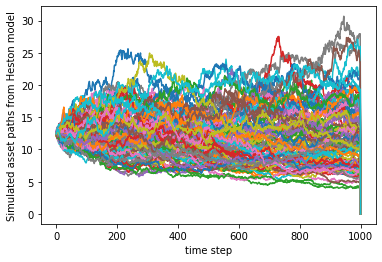

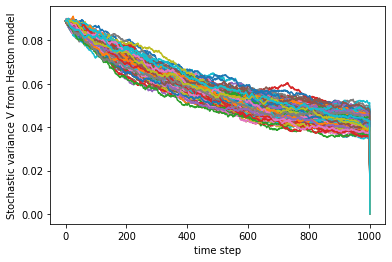

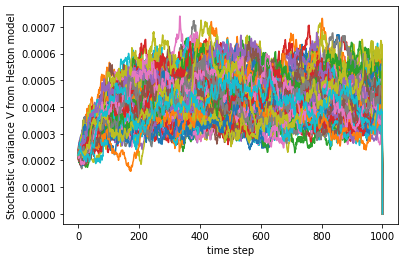

In [10]:
S, v, r, OptionPriceMatrix, stdErrTable, Payoff = pricePutOption(Delta, Omega, chi, v_star, gamma, Lambda, theta, eta, r0, v0, S0, rho_v, rho_r, Tmax, num_steps, num_path, MaturityList, ExercList)
# Plot the graph
plt.close()

fig = plt.figure(1)
plt.plot(S)
plt.ylabel('Simulated asset paths from Heston model')
plt.xlabel('time step')

fig = plt.figure(2)
plt.plot(v)
plt.ylabel('Stochastic variance V from Heston model')
plt.xlabel('time step')

fig = plt.figure(3)
plt.plot(r)
plt.ylabel('Stochastic variance V from Heston model')
plt.xlabel('time step')

In [ ]:
fig = plt.figure(4)
ax = plt.axes(projection='3d')
xx, yy = np.meshgrid(ExercList, MaturityList)
ax.plot_surface(xx, yy, OptionPriceMatrix.T, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('Exercise Price K')
ax.set_ylabel('Maturity T ')
ax.set_zlabel('Option price ')